# Biomass Gasification

<p class="acknowledgement">Written by Prof. William Smith (University of Guelph) and Allan Leal (ETH Zurich) on Mar 31st, 2023</p>

This tutorial demonstrates the use of Reaktoro for biomass gasification in which temperature and exit gas composition are calculated from given Fuel Ultimate Analysis and fuel-to-air ratios.

In [26]:
from reaktoro import *
from numpy import arange

In [28]:
db = NasaDatabase("nasa-cea")

In [30]:
# Inputs -----------------------------------------------------------------------------
massC              = 49.30  # g/mol
massH              = 5.5    # g/mol
massO              = 45.2   # g/mol
HHV                = 18.933 # kJ/g
Q                  = 0.05   # heat loss (%) with respect to HHV
fAirMin            = 0.70   # minimum value for fAir (fuel to air mass ratio)
fAirDelta          = 0.1    # step-size for fAir values
fAirNum            = 30     # number of steps for fAir
output_all_species = False   # if false, output only a few species
# ------------------------------------------------------------------------------------

In [32]:
fAirs = [fAirMin + i * fAirDelta for i in range(fAirNum)]

nC = massC / 12.011
nH = massH / 1.00797
nO = massO / 15.9994

h0CO2 = -393.522  # kJ/g
h0H2O = -285.83   # kJ/g

a = nH / nC
b = nO / nC

formula = ChemicalFormula(f"CH{a}O{b}")

Mfuel = formula.molarMass() * 1000  # from kg/mol to g/mol
Mair = 28.850334  # in g/mol

factor = Mfuel / Mair

HHVmol = HHV * Mfuel

In [34]:
h0fuel = HHVmol + h0CO2 + 0.5*h0H2O*a  # in J/mol
heatDuty = (1 - Q) * HHVmol + h0CO2 + 0.5*h0H2O*a  # in J/mol

In [36]:
stmodelparams = StandardThermoModelParamsConstant()
stmodelparams.G0 = 1.0e+3
stmodel = StandardThermoModelConstant(stmodelparams)

species = Species()
species = species.withName("Fuel")
species = species.withElements(formula.elements())
species = species.withAggregateState(AggregateState.CondensedPhase)
species = species.withStandardThermoModel(stmodel)

db.addSpecies(species)

In [38]:
gases = GaseousPhase(speciate("C H O N"))
condensedphases = CondensedPhases("Fuel H2O(l) C(gr)")

system = ChemicalSystem(db, condensedphases, gases)

In [40]:
specs = EquilibriumSpecs(system)
specs.pressure()
specs.enthalpy()

solver = EquilibriumSolver(specs)

In [42]:
temperatures = []

table = Table()

for fAir in fAirs:
    state = ChemicalState(system)
    state.temperature(25.0, "°C")
    state.pressure(1.0, "bar")
    state.set("Fuel", 1.0, "mol")
    state.set("O2", fAir * factor * 0.21, "mol")
    state.set("N2", fAir * factor * 0.79, "mol")

    props = ChemicalProps(state)
    conditions = EquilibriumConditions(specs)

    conditions.pressure(props.pressure())
    conditions.enthalpy(heatDuty, "kJ")

    conditions.setLowerBoundTemperature(298.15, "°C")
    conditions.setUpperBoundTemperature(3000.0, "°C")

    result = solver.solve(state, conditions)

    assert result.succeeded()

    table.column("Air:Fuel") << fAir
    table.column("Temperature") << state.temperature()
    table.column(f"n(Gases)") << state.props().phaseProps("GaseousPhase").amount()
    
    if output_all_species:
        for species in system.species():
            table.column(f"n({species.name()})") << state.speciesAmount(species.name())
    else:
        table.column("n(C(gr))")    << state.speciesAmount("C(gr)")
        table.column("n(CH4)")      << state.speciesAmount("CH4")
        table.column("n(CO)")       << state.speciesAmount("CO")
        table.column("n(CO2)")      << state.speciesAmount("CO2")
        table.column("n(H2)")       << state.speciesAmount("H2")
        table.column("n(H2O)")      << state.speciesAmount("H2O")
        table.column("n(N2)")       << state.speciesAmount("N2")

In [44]:
table.save("output_fAir.txt")

We now plot the calculated temperatures of the exit stream as a function of the fuel-to-air mass ratio.

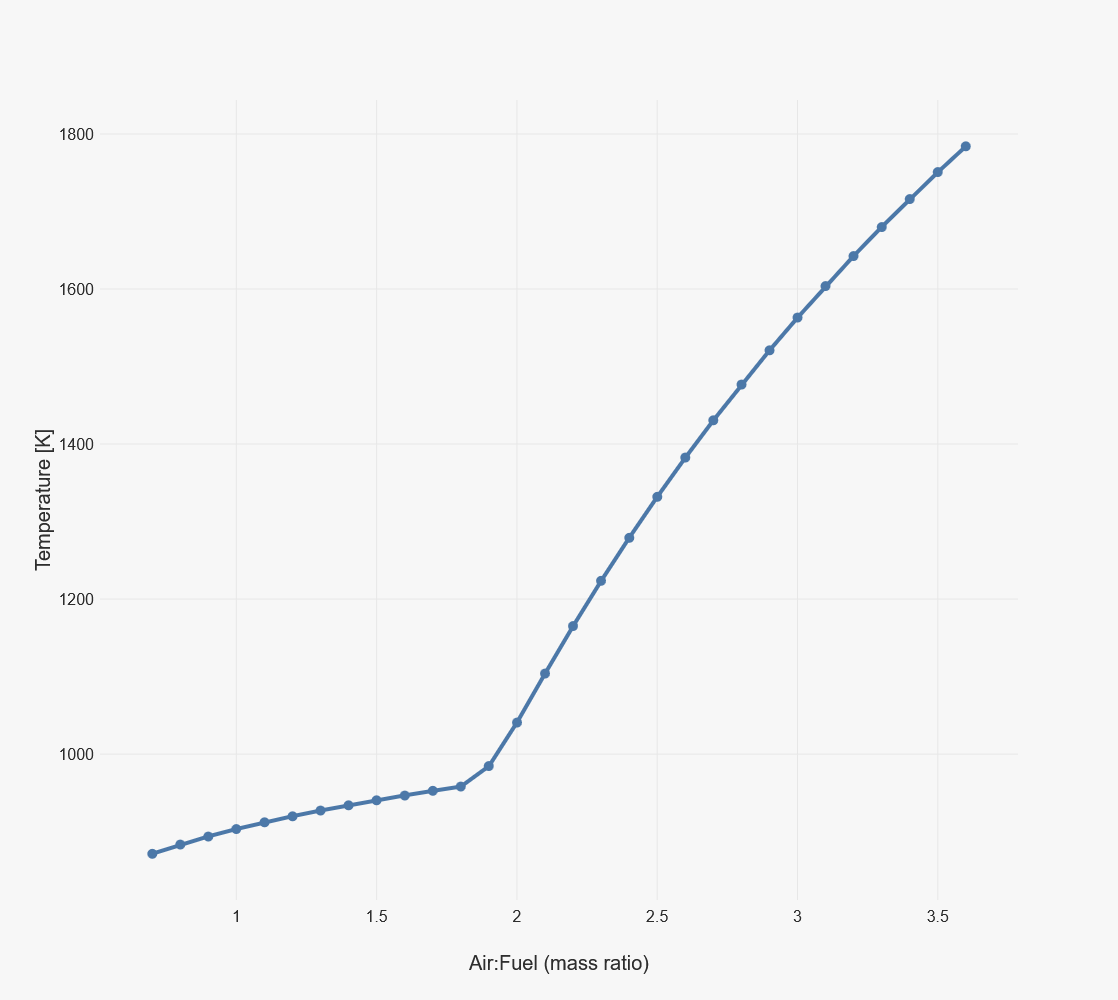

In [47]:
from reaktplot import *

fig = Figure()
fig.xaxisTitle("Air:Fuel (mass ratio)")
fig.yaxisTitle("Temperature [K]")
fig.drawLineWithMarkers(fAirs, table["Temperature"], name="")
fig.height(1000)
fig.show()